# Spatial mapping of cell types across the mouse brain (1/3) - estimating reference expression signatures of cell types

This notebook demonstrates how to use the **cell2location** model for mapping a single cell reference cell types onto a spatial transcriptomic dataset. Here, we use a 10X single nucleus RNA-sequencing (snRNAseq) and Visium spatial transcriptomic data generated from adjacent tissue sections of the mouse brain ([Kleshchevnikov et al., BioRxiv 2020](https://www.biorxiv.org/content/10.1101/2020.11.15.378125v1)). 

Cell2location is a Bayesian model that integrates single-cell RNA-seq (scRNA-seq) and
multi-cell spatial transcriptomics to efficiently map large and comprehensive cell type references (Fig 1). 

![Figure 1.](../images/Fig1_v2.png)  
***Figure 1.*** *Overview of the spatial mapping approach and the workflow which are enabled by cell2location. From left to right: Single-cell RNA-seq and spatial transcriptomics profiles are generated from the same tissue (1). Cell2location takes reference cell type signatures derived from scRNA-seq and spatial transcriptomics data as input (2, 3). The model then decomposes spatially resolved multi-cell RNA counts matrices into the reference signatures, thereby establishing a spatial mapping of cell types (4).*

In the first step covered by this notebook (#2 in Fig 1), we estimate reference cell type signatures from scRNA-seq profiles, for example as obtained using conventional clustering to identify cell types and subpopulations followed by estimation of average cluster gene expression profiles ([Suppl. Methods, Section 2](https://github.com/vitkl/cell2location_paper/blob/master/paper/Supplementary_Methods_cell2location.pdf), [Fig S1](https://github.com/vitkl/cell2location_paper/blob/master/paper/FigS1_cell2location_workflow.pdf)). Cell2location implements this estimation step based on Negative Binomial regression, which allows to robustly combine data across technologies and batches ([Suppl. Methods, Section 2](https://github.com/vitkl/cell2location_paper/blob/master/paper/Supplementary_Methods_cell2location.pdf)).

## Outline

The [**cell2location** workflow](https://github.com/vitkl/cell2location_paper/blob/master/paper/FigS1_cell2location_workflow.pdf) consists of three sections:

I. Estimating reference expression signatures of cell types (1/3, this notebook):

1. [Loading single cell reference data](#1.-Loading-single-cell-reference-data)
2. [Reduce the number of genes by discarding lowly expressed genes](#2.-Reduce-the-number-of-genes-by-discarding-lowly-expressed-genes)
3. [Exploring the data: show UMAP of cells](#3.-Show-UMAP-of-cells)
4. [Estimating expression signatures](#4.-Estimating-expression-signatures)
5. [Additional quality control: removing technical effects and performing standard scanpy single cell analysis workflow](#5.-Additional-quality-control:-removing-technical-effects-and-performing-standard-scanpy-single-cell-analysis-workflow)

II. Spatially mapping cell types (2/3)

III. Results and downstream analysis (3/3)


## Loading packages

First, we need to load the relevant packages. Regression model for estimating expression signatures of cell types cell2location is written in pytorch. While the package works on both GPU and CPU, using the GPU shortens the computation time by ~8 times to just a few minutes.

In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
#branch = "pyro-cell2location"
#user = "vitkl"
#IN_COLAB = "google.colab" in sys.modules

#if IN_COLAB and branch == "stable":
#    !pip install --quiet scvi-tools[tutorials]
#elif IN_COLAB and branch != "stable":
#    !pip install --quiet --upgrade jsonschema
#    !pip install --quiet git+https://github.com/$user/scvi-tools@$branch#egg=scvi-tools[tutorials]
        
#import sys
#if not IN_COLAB:
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/scvi-tools/')

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

#import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pytorch_lightning/metrics/__init__.py:44: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  "`pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package"


## 1. Loading single cell reference data <a name="1.-Loading-single-cell-reference-data"></a>

In [2]:
sc_data_folder = '/nfs/team205/vk7/sanger_projects/large_data/gut_kj_re/'
results_folder = '/nfs/team205/vk7/sanger_projects/collaborations/fetal_gut_mapping/results/'

scvi_run_name = f'{results_folder}regression_model/v1_ye_signatures_lr0002_Adam_SMC_TfH'

Now, we load the pre-processed snRNAseq reference. Scanpy website has tutorials covering how to import other formats.

In [3]:
## snRNA reference (raw counts)
adata_snrna_raw = anndata.read_h5ad(sc_data_folder + "Full_obj_raw_counts_nosoupx.h5ad")

adata_snrna_raw2 = anndata.read_h5ad(sc_data_folder + "FINAL_OBJECT_raw_nosoupx.h5ad")
adata_snrna_raw.obsm = adata_snrna_raw2[adata_snrna_raw.obs_names,:].obsm

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [4]:
adata_snrna_raw.layers, adata_snrna_raw.raw

(Layers with keys: , None)

In [5]:
adata_snrna_raw.obs

,Sample name,Diagnosis,Age,sample name,Region code,Fraction,Gender,Region,10X,batch,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,doublet_scores,predicted_doublets,category,Age_group,Integrated_05
AAACCTGAGAACAACT-1-4918STDY7333456,T036,Pediatric healthy,4,T036-TIL-SC-EPCAMP,TIL,SC-EPCAMP,M,SmallInt,3',4918STDY7333456,968,968,1912.793579,46.228199,2.416790,0.016442,False,B cells,Pediatric,DZ GC cell
AAACCTGAGCGATATA-1-4918STDY7333456,T036,Pediatric healthy,4,T036-TIL-SC-EPCAMP,TIL,SC-EPCAMP,M,SmallInt,3',4918STDY7333456,693,693,2152.089355,0.122579,0.005696,0.027389,False,B cells,Pediatric,Cycling B cell
AAACCTGAGGAGTTTA-1-4918STDY7333456,T036,Pediatric healthy,4,T036-TIL-SC-EPCAMP,TIL,SC-EPCAMP,M,SmallInt,3',4918STDY7333456,720,720,1686.883423,80.195816,4.754082,0.014817,False,T cells,Pediatric,gdT
AAACCTGAGTATCTCG-1-4918STDY7333456,T036,Pediatric healthy,4,T036-TIL-SC-EPCAMP,TIL,SC-EPCAMP,M,SmallInt,3',4918STDY7333456,746,746,2135.183838,104.506760,4.894509,0.039416,False,B cells,Pediatric,Memory B
AAACCTGAGTGACTCT-1-4918STDY7333456,T036,Pediatric healthy,4,T036-TIL-SC-EPCAMP,TIL,SC-EPCAMP,M,SmallInt,3',4918STDY7333456,1227,1227,3103.050293,95.846077,3.088770,0.025763,False,B cells,Pediatric,DZ GC cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCAACACGT-1-WTDAtest7770719,A30 (398B),Healthy adult,20-25,A30-SCL-6-SC-45N-2,SCL,SC-45N,F,LargeInt,3',WTDAtest7770719,1821,1821,4838.415039,144.966095,2.996148,0.027510,False,Mesenchymal,Adult,Stromal 1 (CCL11+)
TTTGGTTTCCAAATGC-1-WTDAtest7770719,A30 (398B),Healthy adult,20-25,A30-SCL-6-SC-45N-2,SCL,SC-45N,F,LargeInt,3',WTDAtest7770719,1814,1814,5337.013672,85.408028,1.600296,0.014349,False,Mesenchymal,Adult,Stromal 1 (CCL11+)
TTTGGTTTCGGCGGTT-1-WTDAtest7770719,A30 (398B),Healthy adult,20-25,A30-SCL-6-SC-45N-2,SCL,SC-45N,F,LargeInt,3',WTDAtest7770719,6418,6418,48142.085938,7198.451172,14.952512,0.072750,False,Epithelial,Adult,Colonocyte
TTTGTCAGTGAAAGAG-1-WTDAtest7770719,A30 (398B),Healthy adult,20-25,A30-SCL-6-SC-45N-2,SCL,SC-45N,F,LargeInt,3',WTDAtest7770719,2578,2578,10848.547852,600.362671,5.534037,0.091348,False,Epithelial,Adult,Stem cells


In [6]:
# checking that data is integer counts
adata_snrna_raw.X.data

array([ 1.,  1.,  1., ...,  3., 30.,  1.], dtype=float32)

## 2. Reduce the number of genes by discarding lowly expressed genes <a name="2.-Reduce-the-number-of-genes-by-discarding-lowly-expressed-genes"></a>

This is performed using 2 cut-off to remove as many lowly expressed genes as possible and yet avoid highly variable gene selection (HVG) which is prone to deleting markers of rare populations:

1. Include all genes expressed by at least 3% of cells (`cell_count_cutoff2`)
2. Include genes expressed by at least 0.02% of cells (`cell_count_cutoff`) when they have high counts in non-zero cells (`nonz_mean_cutoff`)

We prefer this way of selecting genes because step 2 allows retaining genes expressed by rare cell populations but at high levels, whereas standard HVG selection methods can filter out such genes due to their low global mean and variance.

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


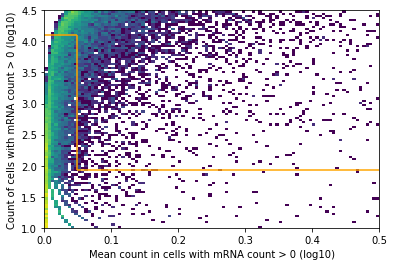

In [7]:
# remove cells and genes with 0 counts everywhere
sc.pp.filter_cells(adata_snrna_raw, min_genes=1)
sc.pp.filter_genes(adata_snrna_raw, min_cells=1)

# calculate the mean of each gene across non-zero cells
adata_snrna_raw.var['n_cells'] = np.array((adata_snrna_raw.X > 0).sum(0)).flatten()
adata_snrna_raw.var['nonz_mean'] = np.array(adata_snrna_raw.X.sum(0)).flatten() \
/ adata_snrna_raw.var['n_cells']

plt.hist2d(np.log10(adata_snrna_raw.var['nonz_mean']),
           np.log10(adata_snrna_raw.var['n_cells']), bins=100,
           norm=mpl.colors.LogNorm(),
           range=[[0,0.5], [1,4.5]]);

nonz_mean_cutoff = np.log10(1.12) # cut off for expression in non-zero cells 
cell_count_cutoff = np.log10(adata_snrna_raw.shape[0] * 0.0002) # cut off percentage for cells with higher expression
cell_count_cutoff2 = np.log10(adata_snrna_raw.shape[0] * 0.03)# cut off percentage for cells with small expression

plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2, color = 'orange');
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1, color = 'orange');
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color = 'orange');
plt.xlabel('Mean count in cells with mRNA count > 0 (log10)');
plt.ylabel('Count of cells with mRNA count > 0 (log10)');

Show the number of selected cells and genes:

In [8]:
adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)].shape

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(428469, 14388)

Filter the object:

In [9]:
# select genes based on mean expression in non-zero cells
adata_snrna_raw = adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)]

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Add counts matrix as `adata.raw` 

In [10]:
adata_snrna_raw.var

,gene_ids,feature_types,n_cells,nonz_mean
SAMD11,ENSG00000187634,Gene Expression,18507,1.303669
NOC2L,ENSG00000188976,Gene Expression,79912,1.269909
PLEKHN1,ENSG00000187583,Gene Expression,1670,1.139521
HES4,ENSG00000188290,Gene Expression,63031,1.925687
ISG15,ENSG00000187608,Gene Expression,85933,1.680542
...,...,...,...,...
AC007325.2,ENSG00000277196,Gene Expression,7871,1.356626
AC004556.1,ENSG00000276345,Gene Expression,17552,1.412660
AC233755.2,ENSG00000277856,Gene Expression,2914,36.021278
AC233755.1,ENSG00000275063,Gene Expression,3495,69.143921


In [11]:
adata_snrna_raw.var['SYMBOL'] = adata_snrna_raw.var_names
adata_snrna_raw.var_names = adata_snrna_raw.var['gene_ids']
adata_snrna_raw.var_names.name = None

Trying to set attribute `.var` of view, copying.


In [12]:
adata_snrna_raw.raw = adata_snrna_raw

## 3. Show UMAP of cells <a name="3.-Show-UMAP-of-cells"></a>

We can examine the cell composition of our data by using a standard scanpy workflow to generate a UMAP representation of the single cell data.

In [13]:
adata_snrna_raw.obs['Integrated_05']

AAACCTGAGAACAACT-1-4918STDY7333456            DZ GC cell
AAACCTGAGCGATATA-1-4918STDY7333456        Cycling B cell
AAACCTGAGGAGTTTA-1-4918STDY7333456                   gdT
AAACCTGAGTATCTCG-1-4918STDY7333456              Memory B
AAACCTGAGTGACTCT-1-4918STDY7333456            DZ GC cell
                                             ...        
TTTGGTTTCAACACGT-1-WTDAtest7770719    Stromal 1 (CCL11+)
TTTGGTTTCCAAATGC-1-WTDAtest7770719    Stromal 1 (CCL11+)
TTTGGTTTCGGCGGTT-1-WTDAtest7770719            Colonocyte
TTTGTCAGTGAAAGAG-1-WTDAtest7770719            Stem cells
TTTGTCATCTTGACGA-1-WTDAtest7770719    Stromal 1 (CCL11+)
Name: Integrated_05, Length: 428469, dtype: category
Categories (133, object): ['Activated CD4 T', 'Activated CD8 T', 'Activated T', 'Adult Glia', ..., 'myofibroblast (RSPO2+)', 'pDC', 'venous capillary', 'β cells (INS+)']

## 4. Estimating expression signatures  <a name="4.-Estimating-expression-signatures"></a> 

### Brief description of the model

**Model-based estimation of reference expression signatures of cell types $g_{f,g}$ using a regularised Negative Binomial regression.** This model robustly derives reference expression signatures of cell types $g_{f,g}$ using the data composed of multiple batches $e=\{1..E\}$ and technologies $t=\{1..T\}$. Adapting the assumptions of a range of computational methods for scRNA-seq, we assume that the expression count matrix follows a Negative Binomial distribution with unobserved expression levels (rates) $\mu_{c,g}$ and a gene-specific over-dispersion $\alpha_g$. We model $\mu_{c,g}$ as a linear function of reference cell type signatures and technical effects:
- $e_e$ denotes a multiplicative global scaling parameter between experiments/batches $e$ (e.g. differences in sequencing depth);
- $t_{t,g}$ accounts for multiplicative gene-specific difference in sensitivity between technologies; 
- $b_{e,g}$ accounts for additive background shift of each gene in each experiment $e$ (proxy for free-floating RNA).


![Model diagram](../images/Regression_model_diagram.png)  

Also see https://cell2location.readthedocs.io/en/latest/cell2location.regression_models.html#regressiongenebackgroundcoveragegenetechnologytorch

```python
help(cell2location.models.RegressionGeneBackgroundCoverageTorch)
```

### Training the model

Here we show how to perform the training of this model wrapped into a singe pipeline function call, how to assess the quality of this model and extract reference signatures of cell types for use with cell2location:

In [14]:
adata_snrna_raw.obs['Diagnosis'].value_counts()

fetal                      247344
Healthy adult              124367
Pediatric healthy           29594
Pediatric Crohn Disease     27164
Name: Diagnosis, dtype: int64

In [15]:
pa_ind = adata_snrna_raw.obs['Diagnosis'].isin([
    'Healthy adult', 'Pediatric healthy'
]) | adata_snrna_raw.obs['Integrated_05'].isin([
    'SMC (PLPP2+)', 'SMC (PART1/CAPN3+)'
])
paediatric_adult = adata_snrna_raw[pa_ind,:]
paediatric_adult.obs['Integrated_05'].value_counts(), adata_snrna_raw.obs['Integrated_05'].value_counts()

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(TA                    44084
 IgA plasma cell       15582
 Enterocyte            15340
 SMC (PLPP2+)          13219
 Colonocyte            11969
                       ...  
 K cells (GIP+)            3
 CLC+ Mast cell            3
 Fetal arterial EC         3
 Stromal 2 (CH25H+)        3
 Fetal venous EC           1
 Name: Integrated_05, Length: 91, dtype: int64,
 TA                     50025
 Enterocyte             37460
 Mesoderm 2 (ZEB2+)     34753
 Mesoderm 1 (HAND1+)    29442
 IgA plasma cell        16882
                        ...  
 ILC2                      48
 LEC2 (MADCAM1+)           47
 N cells (NTS+)            44
 β cells (INS+)            31
 Mesothelium (PRG4+)       25
 Name: Integrated_05, Length: 133, dtype: int64)

In [16]:
paediatric_adult.obs['Integrated_05'].value_counts()[::-1][0:20]

Fetal venous EC           1
Stromal 2 (CH25H+)        3
Fetal arterial EC         3
CLC+ Mast cell            3
K cells (GIP+)            3
M/X cells (MLN/GHRL+)     4
LEC2 (MADCAM1+)           4
Progenitor (NEUROG3+)     6
I cells (CCK+)            6
cycling EC                6
LEC4 (STAB2+)             6
D cells (SST+)            7
venous capillary          8
mLTo                     16
EECs                     17
Stromal 4 (MMP1+)        20
STAT1+ Naive B           23
Mesothelium (PRG4+)      25
N cells (NTS+)           27
pDC                      35
Name: Integrated_05, dtype: int64

## Sub-annotate Tfh cells

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:375: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


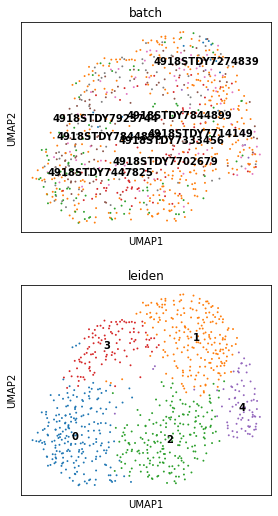

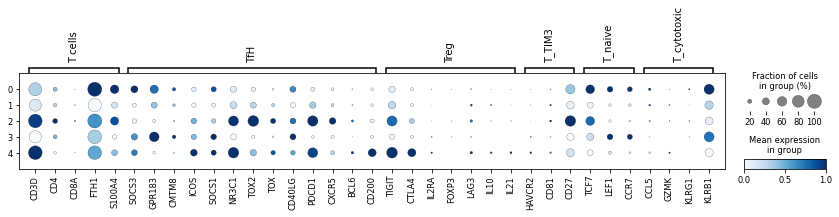

In [17]:
tfh = paediatric_adult[paediatric_adult.obs['Integrated_05'].isin(['Tfh']), :].copy()
batch_sel = tfh.obs['batch'].value_counts()
batch_sel = batch_sel.index[batch_sel > 3]
tfh = tfh[tfh.obs['batch'].isin(batch_sel),:]

#########################
sc.pp.log1p(tfh)

sc.pp.scale(tfh, max_value=10)
sc.tl.pca(tfh, svd_solver='arpack', n_comps=80, use_highly_variable=False)

# Plot total counts over PC to check whether PC is indeed associated with total counts
#sc.pl.pca_variance_ratio(adata_snrna_raw, log=True)
#sc.pl.pca(adata_snrna_raw, color=['total_counts'],
#          components=['0,1', '2,3', '4,5', '6,7', '8,9', '10,11', '12,13'],
#          color_map = 'RdPu', ncols = 3, legend_loc='on data',
#          legend_fontsize=10, gene_symbols='SYMBOL')

# remove the first PC which explains large amount of variance in total UMI count (likely technical variation)
tfh.obsm['X_pca'] = tfh.obsm['X_pca'][:, 1:]
tfh.varm['PCs'] = tfh.varm['PCs'][:, 1:]
#########################

# Here BBKNN (https://github.com/Teichlab/bbknn) is used to align batches (10X experiments) 
import bbknn
bbknn.bbknn(tfh, neighbors_within_batch = 2, batch_key = 'batch', n_pcs = 20)
sc.tl.umap(tfh, min_dist = 0.5, spread = 1.5)

#########################
# Cluster 
sc.tl.leiden(tfh, resolution=0.7)

tfh = tfh[tfh.obs['leiden'].argsort(),:]

with mpl.rc_context({'figure.figsize': [4, 4],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(tfh, color=['batch', 'leiden'], size=15,
               color_map = 'RdPu', ncols = 1, legend_loc='on data',
               legend_fontsize=10)
    
marker_genes_dict = {
'T cells': ["CD3D",  "CD4", "CD8A", "FTH1", "S100A4"],
'TfH': ["SOCS3", "GPR183", "CMTM8","ICOS", "SOCS1", "NR3C1","TOX2", "TOX",
        "CD40LG", "PDCD1", "CXCR5", "BCL6", "CD200"],
'Treg': ["TIGIT", "CTLA4", "IL2RA","FOXP3", "LAG3", "IL10", "IL21"],
'T_TIM3': ["HAVCR2", "CD81", "CD27"],
'T_naive': ['TCF7', "LEF1", "CCR7"],
'T_cytotoxic': ["CCL5",'GZMK',  "KLRG1",  "KLRB1"],
}

with mpl.rc_context({'figure.figsize': [5.2, 3],
                     'axes.facecolor': 'white'}):
    ax = sc.pl.dotplot(tfh, marker_genes_dict, groupby='leiden', 
                       dendrogram=False, standard_scale='var',
                       log=False, cmap="Blues",
                       gene_symbols='SYMBOL',
                       #save='dotplot_Tcells.pdf'
                      )

In [18]:
paediatric_adult.obs['TfH_leiden'] = ''
paediatric_adult.obs.loc[tfh.obs_names, 'TfH_leiden'] = tfh.obs['leiden']

paediatric_adult.obs['Integrated_05_old'] = paediatric_adult.obs['Integrated_05'].copy().astype(str)
paediatric_adult.obs['Integrated_05'] = paediatric_adult.obs['Integrated_05'].copy().astype(str)

paediatric_adult.obs.loc[paediatric_adult.obs['TfH_leiden'].isin(['0', '1', '3']), 
                         'Integrated_05'] = 'CD4+ TfH'
paediatric_adult.obs.loc[paediatric_adult.obs['TfH_leiden'].isin(['2', '4']), 
                         'Integrated_05'] = 'CD4+ TfH GC'

Trying to set attribute `.obs` of view, copying.


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:375: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categor

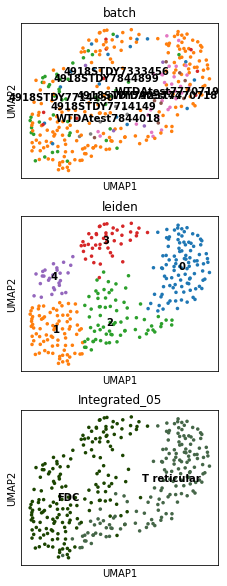

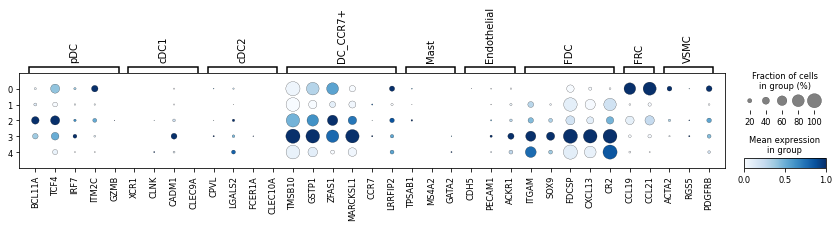

In [32]:
fdc_frc = paediatric_adult[paediatric_adult.obs['Integrated_05'].isin(['T reticular', 'FDC']), :].copy()
batch_sel = fdc_frc.obs['batch'].value_counts()
batch_sel = batch_sel.index[batch_sel > 3]
fdc_frc = fdc_frc[fdc_frc.obs['batch'].isin(batch_sel),:]

#########################
sc.pp.log1p(fdc_frc)

sc.pp.scale(fdc_frc, max_value=10)
sc.tl.pca(fdc_frc, svd_solver='arpack', n_comps=80, use_highly_variable=False)

# Plot total counts over PC to check whether PC is indeed associated with total counts
#sc.pl.pca_variance_ratio(adata_snrna_raw, log=True)
#sc.pl.pca(adata_snrna_raw, color=['total_counts'],
#          components=['0,1', '2,3', '4,5', '6,7', '8,9', '10,11', '12,13'],
#          color_map = 'RdPu', ncols = 3, legend_loc='on data',
#          legend_fontsize=10, gene_symbols='SYMBOL')

# remove the first PC which explains large amount of variance in total UMI count (likely technical variation)
fdc_frc.obsm['X_pca'] = fdc_frc.obsm['X_pca'][:, 1:]
fdc_frc.varm['PCs'] = fdc_frc.varm['PCs'][:, 1:]
#########################

# Here BBKNN (https://github.com/Teichlab/bbknn) is used to align batches (10X experiments) 
import bbknn
bbknn.bbknn(fdc_frc, neighbors_within_batch = 2, batch_key = 'batch', n_pcs = 20)
sc.tl.umap(fdc_frc, min_dist = 0.5, spread = 1.5)

#########################
# Cluster 
sc.tl.leiden(fdc_frc, resolution=0.7)

fdc_frc = fdc_frc[fdc_frc.obs['leiden'].argsort(),:]

with mpl.rc_context({'figure.figsize': [3, 3],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(fdc_frc, color=['batch', 'leiden', 'Integrated_05'], size=50,
               color_map = 'RdPu', ncols = 1, legend_loc='on data',
               legend_fontsize=10)
    
marker_genes_dict = {
    
'pDC': ["BCL11A",  "TCF4", "IRF7", "ITM2C", "GZMB"],    
'cDC1': ["XCR1", "CLNK", "CADM1", "CLEC9A"],
'cDC2': ['CPVL','LGALS2','FCER1A','CLEC10A',],
'DC_CCR7+': ["TMSB10",   "GSTP1", "ZFAS1", "MARCKSL1","CCR7",  "LRRFIP2"],    
'Mast': ["TPSAB1",  "MS4A2","GATA2"],
'Endothelial': ["CDH5","PECAM1", "ACKR1"],
'FDC': ["ITGAM", "SOX9", "FDCSP", "CXCL13", "CR2"],  
'FRC': ["CCL19", "CCL21"],    
'VSMC': ["ACTA2","RGS5", "PDGFRB"],
}

with mpl.rc_context({'figure.figsize': [5.2, 3],
                     'axes.facecolor': 'white'}):
    ax = sc.pl.dotplot(fdc_frc, marker_genes_dict, groupby='leiden', 
                       dendrogram=False, standard_scale='var',
                       log=False, cmap="Blues",
                       gene_symbols='SYMBOL',
                       #save='dotplot_Tcells.pdf'
                      )
    
#paediatric_adult.obs['fdc_frc_leiden'] = ''
#paediatric_adult.obs.loc[fdc_frc.obs_names, 'fdc_frc_leiden'] = fdc_frc.obs['leiden']

#paediatric_adult.obs['Integrated_05'] = paediatric_adult.obs['Integrated_05'].copy().astype(str)

#paediatric_adult.obs.loc[paediatric_adult.obs['fdc_frc_leiden'].isin(['0']), 
#                         'Integrated_05'] = 'T reticular 0'
#paediatric_adult.obs.loc[paediatric_adult.obs['fdc_frc_leiden'].isin(['1']), 
#                         'Integrated_05'] = 'FDC 1'
#paediatric_adult.obs.loc[paediatric_adult.obs['fdc_frc_leiden'].isin(['2']), 
#                         'Integrated_05'] = 'T reticular 2'
#paediatric_adult.obs.loc[paediatric_adult.obs['fdc_frc_leiden'].isin(['3']), 
#                         'Integrated_05'] = 'FDC 3'
#paediatric_adult.obs.loc[paediatric_adult.obs['fdc_frc_leiden'].isin(['4']), 
#                         'Integrated_05'] = 'FDC 4'

## Filter cell types that have too few cells

In [19]:
ct_sel = paediatric_adult.obs['Integrated_05'].value_counts()
ct_sel = ct_sel.index[ct_sel > 8]
paediatric_adult = paediatric_adult[paediatric_adult.obs['Integrated_05'].isin(ct_sel),:]
paediatric_adult.obs['Integrated_05'] = paediatric_adult.obs['Integrated_05'].astype(str)

paediatric_adult.obs['Integrated_05'].value_counts()

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


TA                     44084
IgA plasma cell        15582
Enterocyte             15340
SMC (PLPP2+)           13219
Colonocyte             11969
                       ...  
Mesothelium (PRG4+)       25
STAT1+ Naive B            23
Stromal 4 (MMP1+)         20
EECs                      17
mLTo                      16
Name: Integrated_05, Length: 79, dtype: int64

... storing 'Integrated_05' as categorical
... storing 'TfH_leiden' as categorical
... storing 'Integrated_05_old' as categorical


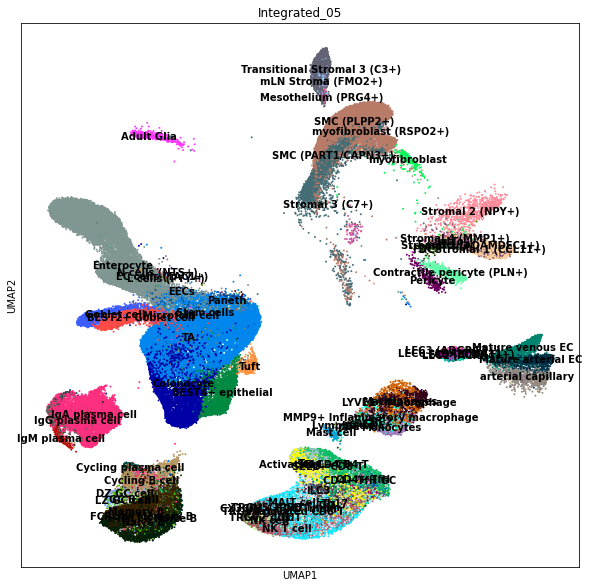

In [20]:
with mpl.rc_context({'figure.figsize': [10, 10],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(paediatric_adult, color=['Integrated_05'], size=15,
               color_map = 'RdPu', ncols = 1, legend_loc='on data',
               legend_fontsize=10)

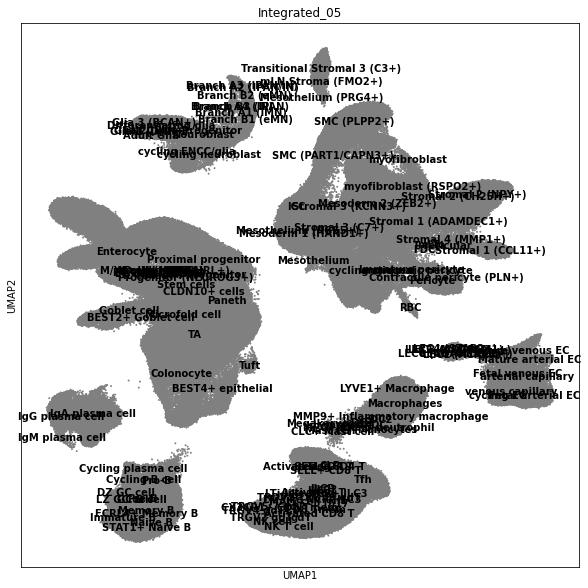

In [21]:
with mpl.rc_context({'figure.figsize': [10, 10],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_snrna_raw, color=['Integrated_05'], size=15,
               color_map = 'RdPu', ncols = 1, legend_loc='on data',
               legend_fontsize=10)

In [22]:
# prepare anndata for scVI model
scvi.data.setup_anndata(adata=paediatric_adult, batch_key='batch', labels_key='Integrated_05',
                        categorical_covariate_keys=['10X']
                       )
scvi.data.view_anndata_setup(paediatric_adult)

INFO     Using batches from adata.obs["batch"]                                               
INFO     Using labels from adata.obs["Integrated_05"]                                        
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorica

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorica

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorica

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorica

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pandas/core/arrays/categorica

INFO     Successfully registered anndata object containing 172854 cells, 14388 vars, 149     
         batches, 79 labels, and 0 proteins. Also registered 1 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


Anndata setup with scvi-tools version 0.0.0.

              Data Summary               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃             Data             ┃ Count  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│            Cells             │ 172854 │
│             Vars             │ 14388  │
│            Labels            │   79   │
│           Batches            │  149   │
│           Proteins           │   0    │
│ Extra Categorical Covariates │   1    │
│ Extra Continuous Covariates  │   0    │
└──────────────────────────────┴────────┘

                    SCVI Data Registry                    
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃          scvi-tools Location           ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │                adata.X                 │
│ batch_indices │        adata.obs['_scvi_batch']        │
│ local_l_mean  │    adata.obs['_scvi_local_l_mean']     │
│  local_l_var  │     adata.obs['_scvi_local_l_var']     │
│    labels     │       adata.obs['_scvi_labels']        │
│   cat_covs    │ adata.obsm['_scvi_extra_categoricals'] │
└───────────────┴────────────────────────────────────────┘

                                  Label Categories                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location       ┃          Categories           ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Integrated_05'] │        Activated CD4 T        │          0          │
│                            │        Activated CD8 T        │          1          │
│                            │          Adult Glia           │          2          │
│                            │      BEST2+ Goblet cell       │          3          │
│                            │       BEST4+ epithelial       │          4          │
│                            │           CD4+ TfH            │          5          │
│                            │          CD4+ TfH GC          │          6          │
│                            │           CD8 Tmem            │          7          │
│                            │       CX3CR1+ CD8 Tmem        │          8          │
│                            │          Colonocyte           │          9          │
│                            │  Contractile pericyte (PLN+)  │         10          │
│                            │        Cycling B cell         │         11          │
│                            │      Cycling plasma cell      │         12          │
│                            │          DZ GC cell           │         13          │
│                            │       EC cells (TAC1+)        │         14          │
│                            │             EECs              │         15          │
│                            │          Enterocyte           │         16          │
│                            │        FCRL4+ Memory B        │         17          │
│                            │              FDC              │         18          │
│                            │           GC B cell           │         19          │
│                            │          Goblet cell          │         20          │
│                            │             ILC3              │         21          │
│                            │        IgA plasma cell        │         22          │
│                            │        IgG plasma cell        │         23          │
│                            │        IgM plasma cell        │         24          │
│                            │        L cells (PYY+)         │         25          │
│                            │         LEC1 (ACKR4+)         │         26          │
│                            │        LEC3 (ADGRG3+)         │         27          │
│                            │        LEC5 (CLDN11+)         │         28          │
│                            │        LEC6 (ADAMTS4+)        │         29          │
│                            │       LYVE1+ Macrophage       │         30          │
│                            │          LZ GC cell           │         31          │
│                            │          Lymphoid DC          │         32          │
│                            │           MAIT cell           │         33          │
│                            │ MMP9+ Inflammatory macrophage │         34          │
│                            │          Macrophages          │         35          │
│                            │           Mast cell           │         36          │
│                            │      Mature arterial EC       │         37          │
│                            │       Mature venous EC        │         38          │
│                            │           Memory B            │         39          │
│                            │      Mesothelium (PRG4+)      │         40          │
│                            │        Microfold cell         │         41          │
│                            │           Monocytes           │         42          │
│    

                          Batch Categories                           
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃       Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │    4918STDY7274839     │          0          │
│                    │    4918STDY7317585     │          1          │
│                    │    4918STDY7317586     │          2          │
│                    │    4918STDY7317587     │          3          │
│                    │    4918STDY7321513     │          4          │
│                    │    4918STDY7321514     │          5          │
│                    │    4918STDY7333456     │          6          │
│                    │    4918STDY7389431     │          7          │
│                    │    4918STDY7421297     │          8          │
│                    │    4918STDY7421298     │          9          │
│                    │    4918STDY7421299     │         10          │
│                    │    4918STDY7426904     │         11          │
│                    │    4918STDY7426905     │         12          │
│                    │    4918STDY7426906     │         13          │
│                    │    4918STDY7426907     │         14          │
│                    │    4918STDY7426908     │         15          │
│                    │    4918STDY7426909     │         16          │
│                    │    4918STDY7447825     │         17          │
│                    │    4918STDY7693757     │         18          │
│                    │    4918STDY7693758     │         19          │
│                    │    4918STDY7693759     │         20          │
│                    │    4918STDY7693760     │         21          │
│                    │    4918STDY7693761     │         22          │
│                    │    4918STDY7693762     │         23          │
│                    │    4918STDY7693763     │         24          │
│                    │    4918STDY7702679     │         25          │
│                    │    4918STDY7702680     │         26          │
│                    │    4918STDY7714149     │         27          │
│                    │    4918STDY7714150     │         28          │
│                    │    4918STDY7717783     │         29          │
│                    │    4918STDY7717784     │         30          │
│                    │    4918STDY7717785     │         31          │
│                    │    4918STDY7717787     │         32          │
│                    │    4918STDY7717788     │         33          │
│                    │    4918STDY7717789     │         34          │
│                    │    4918STDY7718972     │         35          │
│                    │    4918STDY7718973     │         36          │
│                    │    4918STDY7718974     │         37          │
│                    │    4918STDY7718975     │         38          │
│                    │    4918STDY7718976     │         39          │
│                    │    4918STDY7718977     │         40          │
│                    │    4918STDY7844898     │         41          │
│                    │    4918STDY7844899     │         42          │
│                    │    4918STDY7923744     │         43          │
│                    │     FCA_gut8015057     │         44          │
│                    │     FCA_gut8015058     │         45          │
│                    │     FCA_gut8015059     │         46          │
│                    │     FCA_gut8015060     │         47          │
│                    │     FCA_gut9456313     │         48          │
│                    │     FCA_gut9456316     │         49          │
│                    │     FCA_gut9456319     │         50          │
│                    │     FCA_gut9456322     │         51          │
│                    │     FCA_gut9456326     │         52          │
│         

              Extra Categorical Variables              
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Source Location  ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['10X'] │     3'     │          0          │
│                  │     5'     │          1          │
│                  │            │                     │
└──────────────────┴────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  rank_zero_warn(f'you passed in a {loader_name} but have no {step_name}. Skipping {stage} loop')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|██████████| 999/999 [01:05<00:00, 15.23it/s]


'/nfs/team205/vk7/sanger_projects/collaborations/fetal_gut_mapping/results/regression_model/v1_ye_signatures_lr0002_Adam_SMC_TfH/sc.h5ad'

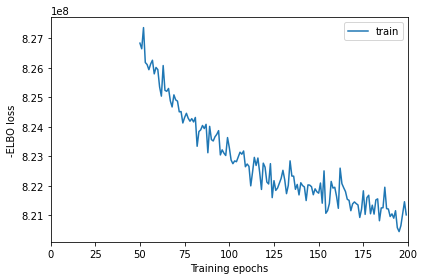

In [23]:
# create and train the model
import pyro
from scvi.external.cell2location._reference_module import RegressionModel
mod = RegressionModel(
    paediatric_adult,
    #amortised=True, encoder_mode="single",
    #encoder_kwargs={'dropout_rate': 0.1}
) 

mod.train(max_epochs=200, 
          batch_size=2500, 
          train_size=1,
          #plan_kwargs={'optim': pyro.optim.ClippedAdam(optim_args={'lr': 0.002, 'clip_norm': 10})},
          plan_kwargs={'optim': pyro.optim.Adam(optim_args={'lr': 0.002})},
          use_gpu=True)

# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(50)

# In this section, we export the estimated cell abundance (summary of the posterior distribution).
paediatric_adult = mod.export_posterior(
    paediatric_adult, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{scvi_run_name}", overwrite=True)
# can be loaded later like this:
# mod = scvi.external.cell2location.RegressionModel.load(f"{scvi_run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{scvi_run_name}/sc.h5ad"
paediatric_adult.write(adata_file)
adata_file

Examine QC plots

1. Reconstruction accuracy to assess if there are any issues with inference.

2. The estimated expression signatures are distinct from mean expression in each cluster because of batch effects. For scRNA-seq datasets which do not suffer from batch effect (this dataset does), cluster average expression can be used instead of estimating signatures with a model. When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, density everywhere) it indicates problems with signature estimation.

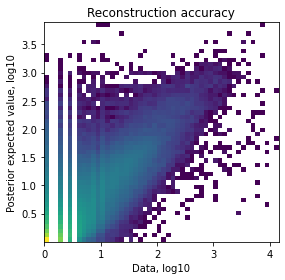

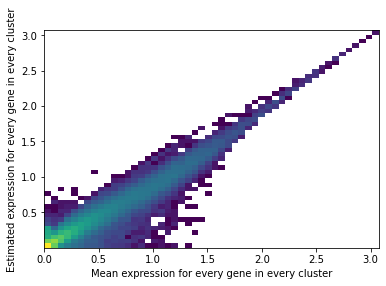

In [24]:
mod.plot_QC()

## 5. Additional quality control: removing technical effects and performing standard scanpy single cell analysis workflow <a name="5.-Additional-quality-control:-removing-technical-effects-and-performing-standard-scanpy-single-cell-analysis-workflow"></a>

This allows to identify if the model successfully accounted for technical factor by checking whether removing contribution those factors from every single cell leads to merging of samples / batches, yet preserves well-separated cell types in the UMAP space.

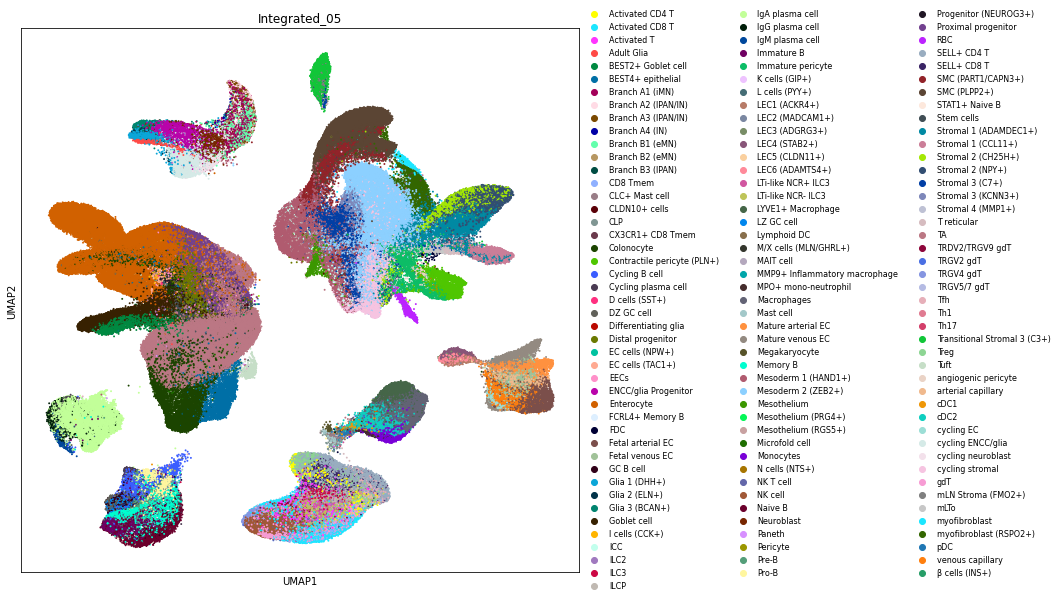

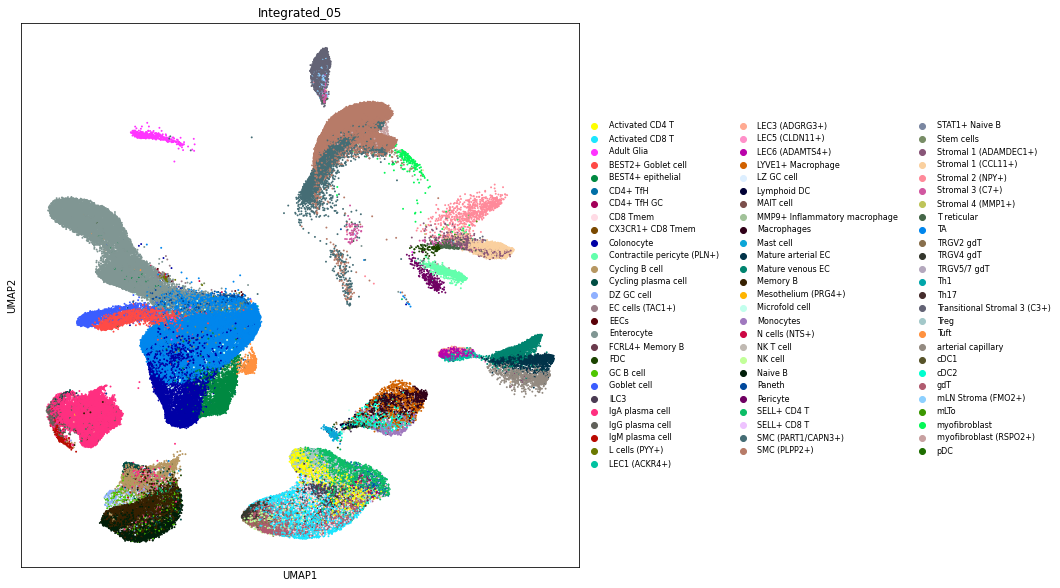

In [25]:
fig_path = f'{scvi_run_name}/figures/'
sc.settings.figdir = f'{fig_path}'

with mpl.rc_context({'figure.figsize': [10, 10],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_snrna_raw, color=['Integrated_05'], size=15,
               color_map = 'RdPu', ncols = 1, #legend_loc='on data',
               palette = sc.pl.palettes.default_102 + sc.pl.palettes.zeileis_28 + sc.pl.palettes.vega_20_scanpy,
               legend_fontsize=8, save='full_human_gut_umap_cluster.pdf')
    
with mpl.rc_context({'figure.figsize': [10, 10],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(paediatric_adult, color=['Integrated_05'], size=15,
               color_map = 'RdPu', ncols = 1, #legend_loc='on data',
               palette = sc.pl.palettes.default_102 + sc.pl.palettes.zeileis_28 + sc.pl.palettes.vega_20_scanpy,
               legend_fontsize=8, save='adult_paed_human_gut_umap_cluster.pdf')

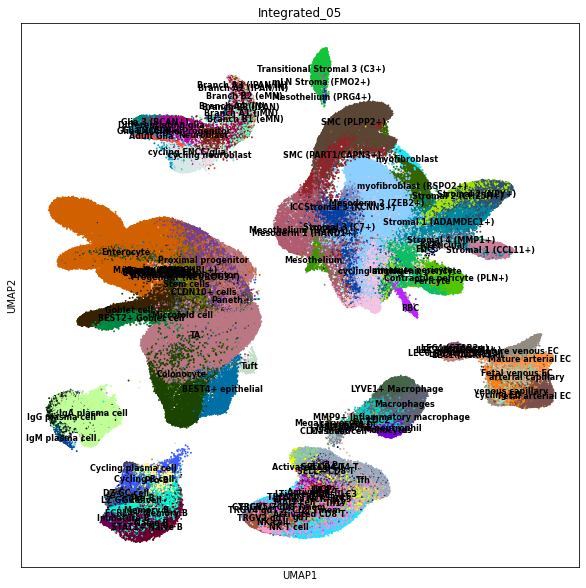

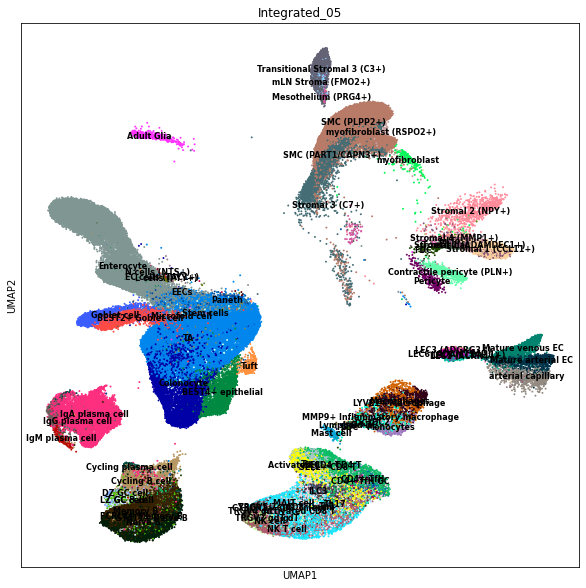

In [26]:
fig_path = f'{scvi_run_name}/figures/'
sc.settings.figdir = f'{fig_path}'

with mpl.rc_context({'figure.figsize': [10, 10],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_snrna_raw, color=['Integrated_05'], size=15,
               color_map = 'RdPu', ncols = 1, legend_loc='on data',
               palette = sc.pl.palettes.default_102 + sc.pl.palettes.zeileis_28 + sc.pl.palettes.vega_20_scanpy,
               legend_fontsize=8, #save='full_human_gut_umap_cluster.pdf'
              )
    
with mpl.rc_context({'figure.figsize': [10, 10],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(paediatric_adult, color=['Integrated_05'], size=15,
               color_map = 'RdPu', ncols = 1, legend_loc='on data',
               palette = sc.pl.palettes.default_102 + sc.pl.palettes.zeileis_28 + sc.pl.palettes.vega_20_scanpy,
               legend_fontsize=8, #save='adult_paed_human_gut_umap_cluster.pdf'
              )

Modules and their versions used for this analysis

In [27]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(sys.modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

sys 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
[GCC 9.3.0]
ipykernel 5.5.3
ipykernel._version 5.5.3
json 2.0.9
re 2.2.1
IPython 7.22.0
IPython.core.release 7.22.0
logging 0.5.1.2
zlib 1.0
traitlets 5.0.5
traitlets._version 5.0.5
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
IPython.core.crashhandler 7.22.0
pygments 2.8.1
pexpect 4.8.0
ptyprocess 0.7.0
decorator 5.0.6
pickleshare 0.7.5
backcall 0.2.0
sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
_sqlite3 2.6.0
prompt_toolkit 3.0.18
wcwidth 0.2.5
jedi 0.18.0
parso 0.8.2
colorama 0.4.4
ctypes 1.1.0
_ctypes 1.1.0
IPython.core.magics.code 7.22.0
urllib.request 3.7
jupyter_client 6.1.12
jupyter_client._version 6.1.12
zmq 22.0.3
zmq.backend.cython 40304
zmq.backend.cython.constants 40304
zmq.sugar 22.0.3
zmq.sugar.constants 40304
zmq.sugar.version 22.0.3
jupyter_core 4.7.1
jupyter_core.version 4.7.1
tornado 6.1
_curses b'2.2'
dateutil 2.8.1
dateutil._version 2.8.1
six 1.15.0
decimal 1.70
_de